### Executar no Kaggle

In [50]:
HYPERNYM_PATH = '/kaggle/input/hypernym1/train_rnd.csv'
TRAIN_ESSAYS_PATH = '/kaggle/input/bless-dataset/assembled-pairs.json'

TEST_ESSAYS_PATH = '/kaggle/input/hypernym1/test_rnd.csv'
TRAIN_PROMPTS_PATH = '/kaggle/input/hypernym1/validation_rnd.csv'


# TRAIN_ESSAYS_PATH = '/kaggle/input/llm-detect-ai-generated-text/train_essays.csv'
# TEST_ESSAYS_PATH = '/kaggle/input/llm-detect-ai-generated-text/test_essays.csv'
# TRAIN_PROMPTS_PATH = '/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv'

# MODEL_PATH = '/kaggle/input/bertbaseconstantlearningerrado'
# MODEL_PATH = '/kaggle/input/d/faguim/modelo3'
# MODEL_PATH = '/kaggle/input/bertlarge2eminus5-zip'
# MODEL_PATH = '/kaggle/working/output_dir/checkpoint-7728'

MODEL_PATH = 'bert-base-cased'

In [51]:
# !ls -lh /kaggle/input

In [54]:
import pandas as pd

# train_essays = []
t_hypernym = pd.read_csv(HYPERNYM_PATH)
t_hypernym.columns = ['x', 'hypernym', 'label']

t_essays = pd.read_json(TRAIN_ESSAYS_PATH)

test_essays = pd.read_csv(TEST_ESSAYS_PATH)
train_prompts = pd.read_csv(TRAIN_PROMPTS_PATH)

# ext_df1 = pd.read_csv('/kaggle/input/propertrain-dataset/train_drcat_01.csv')
# ext_df2 = pd.read_csv('/kaggle/input/propertrain-dataset/train_drcat_02.csv')
# ext_df3 = pd.read_csv('/kaggle/input/propertrain-dataset/train_drcat_03.csv')
# ext_df4 = pd.read_csv('/kaggle/input/propertrain-dataset/train_drcat_04.csv')

# t_essays['label'] = t_essays.false.copy()
t_essays.columns = ['x', 'hypernym', 'label']

t_essays = pd.concat([
    t_essays,
    t_hypernym
])

# ext_df.drop(['id', 'essay_id', 'source', 'prompt', 'prompt_id', 'fold', 'generated'], axis='columns', inplace=True)
# t_essays.drop_duplicates(keep='first', inplace=True)
# t_essays["label"] = t_essays["label"].astype(int)
print(t_essays)

train_essays = t_essays.copy().reset_index(drop=True)

              x       hypernym  label
0      pheasant           game      1
1      pheasant           bird      1
2      pheasant     vertebrate      1
3      pheasant       creature      1
4          dove       pheasant      0
...         ...            ...    ...
49470     vinni         sauvik      0
49471    scutus  fissurellidae      0
49472  pyramids           isbn      0
49473   aharoni       typeface      1
49474      call   organization      1

[55761 rows x 3 columns]


In [56]:
train_essays

,x,hypernym,label
0,pheasant,game,1
1,pheasant,bird,1
2,pheasant,vertebrate,1
3,pheasant,creature,1
4,dove,pheasant,0
...,...,...,...
55756,vinni,sauvik,0
55757,scutus,fissurellidae,0
55758,pyramids,isbn,0
55759,aharoni,typeface,1


In [57]:
!pip install --upgrade -q wandb git+https://github.com/soumik12345/wandb-addons

import wandb  # Import wandb library for experiment tracking
import wandb_addons # Additional wandb utilities

try:
    from kaggle_secrets import UserSecretsClient  # Import UserSecretsClient
    user_secrets = UserSecretsClient()  # Create secnovo3 = test_dataset2.map(tokenize)rets client instance
    api_key = user_secrets.get_secret("WANDB")  # Get API key from Kaggle secrets
    wandb.login(key=api_key)  # Login to wandb with the API key
    anonymous = None  # Set anonymous mode to None
    wandb.init() 
    wandb.log()
except:
    anonymous = 'must'  # Set anonymous mode to 'must'
    wandb.login(anonymous=anonymous, relogin=True)  # Login to wandb anonymously and relogin if needed

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [58]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

print('Dispositivo:', device)
torch.cuda.get_device_name(device)

Dispositivo: cuda


'Tesla P100-PCIE-16GB'

In [59]:
from datasets import load_dataset
from transformers import (
    TrainingArguments,
    Trainer,
    AutoTokenizer,
    AutoModelForSequenceClassification,  
    EvalPrediction,
)

In [60]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
# tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, max_length=512, model_max_length=512)
# tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, max_length=1024, model_max_length=1024)

# tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, max_length=1024)
# tokenizer = AutoTokenizer.from_pretrained(BERT_PATH, max_length=1024)
# print(type(tokenizer))


def tokenize(examples):
    pair=examples['x']+ '[SEP]' +examples['hypernym']
#     print(pair)
#     print(examples['tokens'])
    s = tokenizer(pair, truncation=True)
#     print(s)
#     print(len(s.get('input_ids')))
#     print(s)
    return s

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/vocab.txt
loading file tokenize

In [61]:
from datasets import Dataset 

train_dataset = Dataset.from_dict(train_essays)
# print(train_dataset)
tokenized_train_dataset = train_dataset.map(tokenize)
tokenized_train_dataset = tokenized_train_dataset.remove_columns(['x', 'hypernym'])

train_split, eval_split, test_split = torch.utils.data.random_split(tokenized_train_dataset, [0.7,0.15, 0.15])

  0%|          | 0/55761 [00:00<?, ?ex/s]

In [62]:
tokenized_train_dataset

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 55761
})

In [63]:
# train_split[0]["input_ids"]
train_split[0]

{'label': 1,
 'input_ids': [101, 23280, 1306, 102, 1491, 102],
 'token_type_ids': [0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [64]:
model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_PATH,
#         BERT_PATH,
        num_labels=2,
#         max_position_embeddings=512,
#     ignore_mismatched_sizes=True
#         use_safetensors=True,
    )

training_args = TrainingArguments(
        output_dir="output_dir",
#         eval_delay=0,
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        weight_decay=3e-6,
        adam_beta1=0.9,
        adam_beta2=0.999,
        adam_epsilon=1e-8,
#     num_cycles=3,
        num_train_epochs=2,
#         lr_scheduler_type="constant",
        warmup_steps=55,
        log_level="info",
        save_strategy="epoch",
        save_total_limit = 1,
#         load_best_model_at_end = True,
#         seed=43,
#         fp16=True,
#         dataloader_drop_last=True,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,

    )

trainer = Trainer(
        model,
        training_args,
        tokenizer=tokenizer,
#         data_collator=collator,cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)
        train_dataset=train_split,
        eval_dataset=eval_split
    )

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/model.safetenso

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/model.safetenso

bert-base-cased


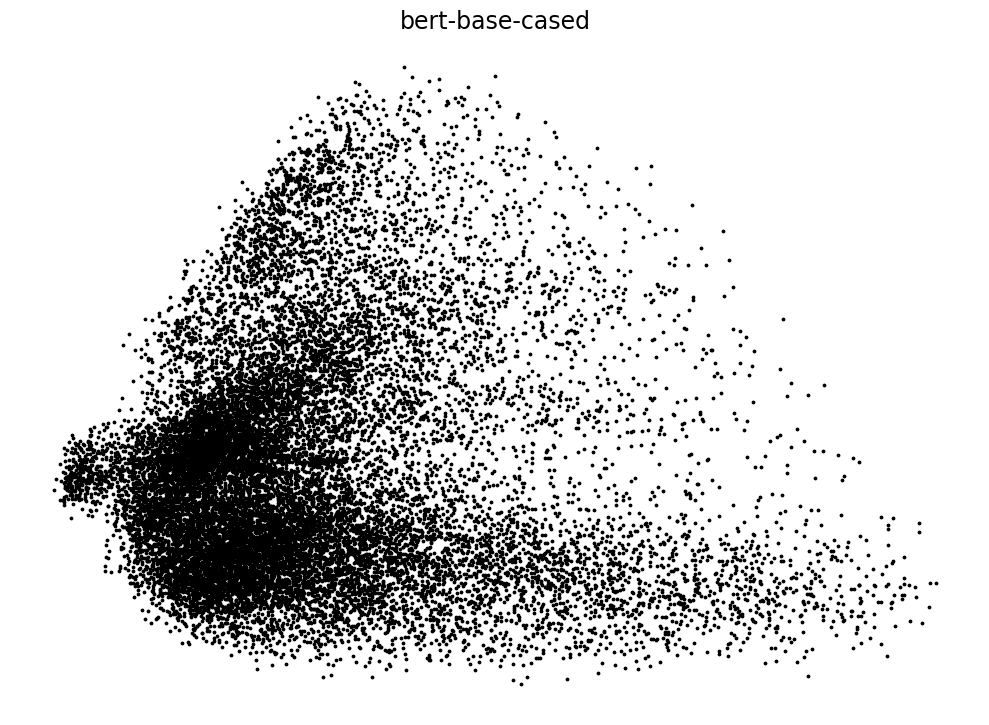

In [65]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

embeds = model.state_dict()['bert.embeddings.word_embeddings.weight'] 
embeds = embeds.tolist()
# model.state_dict()['embeddings.word_embeddings.weight'] 

#  = words = list(tokenizer.vocab.keys())

X_reduzido = embeds[:20000]
# words_reduzido = words[:10000]

from sklearn import manifold
# X_reduzido.cpu()
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X_reduzido)

from matplotlib import pyplot as plt
import os
import numpy as np

IMG_PATH = 'imgs/'

if not os.path.exists(IMG_PATH):
    os.mkdir(IMG_PATH)

IMG_NAME = MODEL_PATH.replace('/', "-").replace('.', "-")
print(IMG_NAME)

def plot_clustering(X_red, title=None):
    # X_grandao = X_red
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)
    # X_grandao.append(X_red)

    plt.figure(figsize=(10, 8))
    
    plt.scatter(X_red[:, 0], X_red[:, 1], color='black', s=3)
    
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(IMG_PATH + title)

plot_clustering(X_red, IMG_NAME)

In [66]:
trainer.train()
trainer.save_model()

***** Running training *****
  Num examples = 39,033
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 4,880
  Number of trainable parameters = 108,311,810
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,0.155400,0.161632
2,0.101600,0.181374


***** Running Evaluation *****
  Num examples = 8364
  Batch size = 16
Saving model checkpoint to output_dir/checkpoint-2440
Configuration saved in output_dir/checkpoint-2440/config.json
Model weights saved in output_dir/checkpoint-2440/pytorch_model.bin
tokenizer config file saved in output_dir/checkpoint-2440/tokenizer_config.json
Special tokens file saved in output_dir/checkpoint-2440/special_tokens_map.json
Deleting older checkpoint [output_dir/checkpoint-552] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 8364
  Batch size = 16
Saving model checkpoint to output_dir/checkpoint-4880
Configuration saved in output_dir/checkpoint-4880/config.json
Model weights saved in output_dir/checkpoint-4880/pytorch_model.bin
tokenizer config file saved in output_dir/checkpoint-4880/tokenizer_config.json
Special tokens file saved in output_dir/checkpoint-4880/special_tokens_map.json
Deleting older checkpoint [output_dir/checkpoint-2440] due to args.save_total_limit


T

------------------------------------------------
# Teste

In [67]:
result = trainer.evaluate(test_split)
result

***** Running Evaluation *****
  Num examples = 8364
  Batch size = 16


{'eval_loss': 0.17859522998332977,
 'eval_runtime': 7.4592,
 'eval_samples_per_second': 1121.294,
 'eval_steps_per_second': 70.114,
 'epoch': 2.0}

loading configuration file /kaggle/working/output_dir/config.json
Model config BertConfig {
  "_name_or_path": "/kaggle/working/output_dir",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.35.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file /kaggle/working/output_dir/model.safetensors
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of

-kaggle-working-output_dir


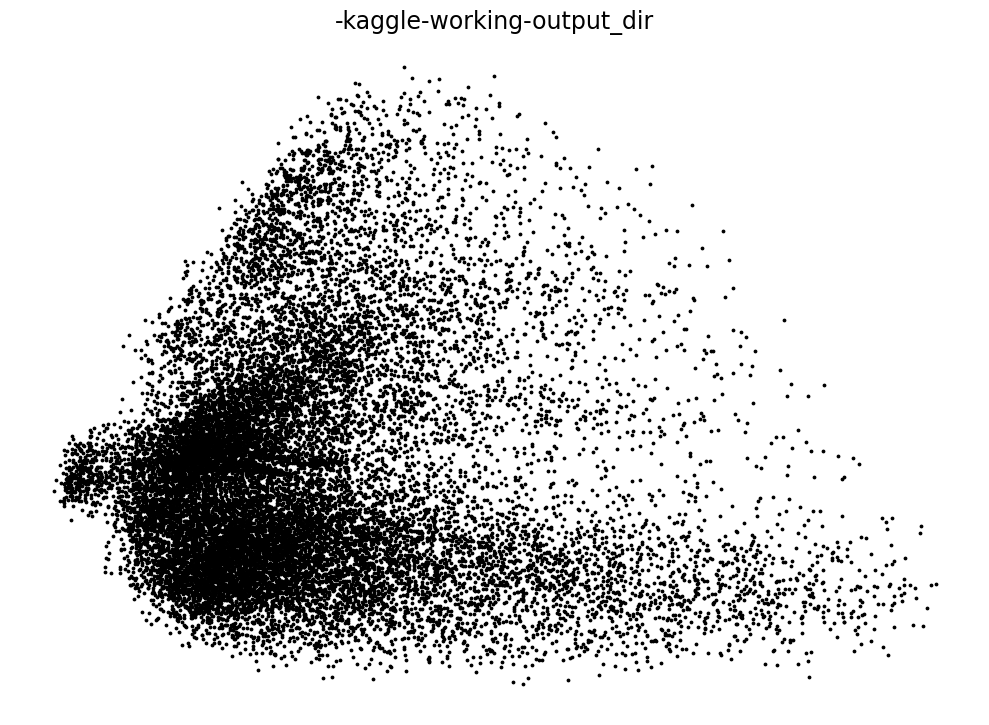

In [68]:
MODEL_PATH = '/kaggle/working/output_dir'
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

embeds = model.state_dict()['bert.embeddings.word_embeddings.weight'] 
embeds = embeds.tolist()
# model.state_dict()['embeddings.word_embeddings.weight'] 

#  = words = list(tokenizer.vocab.keys())

X_reduzido = embeds[:20000]
# words_reduzido = words[:10000]

from sklearn import manifold
# X_reduzido.cpu()
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X_reduzido)

from matplotlib import pyplot as plt
import os
import numpy as np

IMG_PATH = 'imgs/'

if not os.path.exists(IMG_PATH):
    os.mkdir(IMG_PATH)

IMG_NAME = MODEL_PATH.replace('/', "-").replace('.', "-")
print(IMG_NAME)

def plot_clustering(X_red, title=None):
    # X_grandao = X_red
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)
    # X_grandao.append(X_red)

    plt.figure(figsize=(10, 8))
    
    plt.scatter(X_red[:, 0], X_red[:, 1], color='black', s=3)
    
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(IMG_PATH + title)

plot_clustering(X_red, IMG_NAME)

In [69]:
# # # # 1: 'eval_loss': 0.018171824514865875,
# # # # 2:'eval_loss': 0.019168734550476074
# # # # 3: 'eval_loss': 0.016240527853369713'
        
        
        
# # # #         ---------------
# # # #     Modelo 4    
# # # # Epoch 	Training Loss 	Validation Loss --> Test
# # # # 1 	0.038200 	0.133390
# # # # 2 	0.029200 	0.043577
# # # # 3 	0.013600 	0.039176 ---> 0.037069786339998245

# # # 10EPOCHS
# # # 1 	0.040600 	0.033435
# # # 2 	0.016000 	0.035558
# # # 3 	0.010200 	0.031337
# # # 4 	0.012400 	0.043263
# # # 5 	0.006100 	0.041467
# # # 6 	0.004400 	0.039544
# # # 7 	0.003000 	0.048936
# # # 8 	0.000000 	0.045338
# # # 9 	0.000000 	0.046916
# # # 10 	0.000000 	0.047661

# # # 7EPOCHS
# # # 1 	0.032500 	0.044884
# # # 2 	0.016900 	0.019400
# # # 3 	0.005200 	0.038988  0.015834501013159752,
# # # 4 	0.004300 	0.020831  0.00468977726995945
# # # 5 	0.003600 	0.045806  0.017297109588980675
# # # 6 	0.000100 	0.037682  0.013847769238054752
# # # 7 	0.000000 	0.031262  0.013523745350539684


# # # 5epochslarge, lr 3e-5
# # # 5 0.6 --> 0.6 --> 0.6283125877380371


# # # 2epochslarge, lr 2e-5
# # # 1 	0.032600 	0.015285   0.00930606760084629,
# # # 2 	0.007400 	0.011398   0.018849071115255356

# # # ---------------------------
# # # 1epochslarge, lr 3e-5
# # # x --> x --> test_loss': 0.15940824151039124,


        
    
# # bert-base learning_rate=3e-5, warmup steps desconfigurado
# # 1 	0.035900 	0.020002   0.011627799831330776,
# # 2 	0.014300 	0.026277   0.046091921627521515
# # 3 	0.004200 	0.021399   0.026681404560804367



# # bert-base learning_rate=3e-5, warmup steps 10%
# # 0.01594146341085434
# # 0.023494239896535873
# # 0.0223104078322649



# # bert-base learning_rate=2e-5, warmup steps 10%

# 1 	0.028800 	0.011249   0.006494616623967886
# 2 	0.015200 	0.013231   0.004830355755984783
# 3 	0.006000 	0.017011   0.02094988152384758


# bert-base 5e-5  warmup steps 10%
# 1 	0.038900 	0.028577  0.012289708480238914
# 2 	0.017700 	0.024407  0.01493032556027174
# 3 	0.007900 	0.045755  0.030657973140478134
# 4 	0.005000 	0.023188
# 5 	0.003300 	0.023409   0.023820417001843452



# bert-large 2e-5  warmup steps 10%

# 1 	0.057900 	0.050056
# 2 	0.031500 	0.028740
# 3 	0.017000 	0.016659
# 4 	0.015300 	0.019737
# 5 	0.011300 	0.021252  0.011726350523531437,


# bert-base constant-learning   5 epochs warmup_steps=579 (deveria ter 10%, taerrado)
# 1 	0.036700 	0.030619    0.02572002448141575
# 2 	0.022700 	0.014526    0.0069252680987119675
# 3 	0.020000 	0.017621    0.01026342622935772
# 4 	0.005300 	0.024898    0.009119929745793343
# 5 	0.005100 	0.022127 --> 0.01931276172399521

utils

In [72]:
# !zip -r bertbaseconstantlearningerrado.zip /kaggle/working/output_dir/checkpoint-3864

# from IPython.display import FileLink
# FileLink(r'bertbaseconstantlearningerrado.zip')

In [73]:
# !rm -r output_dir/

In [74]:
# # !rm -r wandb/
# !rm -r /kaggle/input/d/faguim/modelo3

In [75]:
# !ls output_dir/ -lh

In [76]:
# import os
# os.remove("state.db")